# 2D BCSD Crack example (2DP1)

Instead of just one collocation point per element like in the case of the 2DP0 kernel, the 2DP1 kernel has 2 collocation points.

The displacement boundary conditions are specified as follows,
$$
D(x) = {2 (1-\nu) \tau_F \over \pi G} \{ x \ln \big| {x\sqrt{c^2 - a^2} + a\sqrt{c^2 - x^2} \over x\sqrt{c^2 - a^2} - a\sqrt{c^2 - x^2}} \big| - a \ln \big| {\sqrt{c^2 - a^2} + \sqrt{c^2 - x^2} \over \sqrt{c^2 - a^2} - \sqrt{c^2 - x^2}} \big| \}
$$

We construct an augmented collocation matrix to place two collocation points per element.

The analytical traction solution for the BCSD crack is given as seen in Weertman (1996), 
$$
t(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |a|\\
        \sigma_A-\tau_F & \text{if } |c| \geq x > |a|
    \end{cases}
$$

In [1]:
import numpy as np
import sys
import os
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
#plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

home = os.environ['HOME'] 
# sys.path.append(home + "/geolab/dev_bigwham/build/interfaces/python")
# from bigwham4py import Hmatrix  # linear operator file

sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
alpha = 1 - nu

tau_F = 1.0
sigma_A = (2 * tau_F)/3

ct_pressure = -sigma_A
pz_pressure = tau_F - sigma_A

pre_fac = - 2 * ((alpha*tau_F) / (np.pi*G))

a = 1.0 
c = 2.0

In [3]:
#plastic zone formula
#pz_fac_2 = 1 + 2*pz_fac*np.sin((np.pi*sigma_A)/(4*tau_F))**2
#c_2 = a*pz_fac_2

# Mesh
nelts = 100
coor1D = np.linspace(-c, c, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameters
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-4

# Hmatrix
kernel = "2DP1"
elas_prop = np.array([E, nu])
hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

# get augmented collocation points
col_pts_aug = np.zeros((conn.shape[0] * 2, conn.shape[1]))
count = 0
col_pts_aug[count, :] = coor[0, :]
count += 1
for i in range(1, coor.shape[0] -  1):
    col_pts_aug[count, :] = coor[i, :]
    count += 1
    col_pts_aug[count, :] = coor[i, :]
    count += 1
col_pts_aug[count, :] = coor[i+1, :]

 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  3.055e-06
Binary cluster tree depth = 1
Number of blocks = 4
Number of full blocks = 4
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.028887
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


In [4]:
dd = np.zeros(col_pts_aug.shape)

pzl2 = np.sqrt(c**2 - a**2) 
x_pzl2 = col_pts_aug[:, 0]*pzl2
ctzl2 = np.sqrt(c**2 - col_pts_aug[:, 0]**2)
a_ctzl2 = a*ctzl2

#dd_alt = np.zeros(col_pts_aug.shape)
#for i in range(len(col_pts_aug)):
#    if x_pzl2[i] + a_ctzl2[i] == 0:
#        
#    else:
#        disp = pre_fac * (col_pts_aug[:, 0][i]*np.log(abs((x_pzl2[i] + a_ctzl2[i])/(x_pzl2[i] - a_ctzl2[i]))) - a*np.log(abs((pzl2 + ctzl2[i])/(pzl2 - ctzl2[i]))))
#        dd_alt[:, 1][i] = disp

print(len(dd))
print(int(len(dd)/4))
print(int(3*len(dd)/4))
#problem - nan value at derivative discontinuity
dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
dd[:, 1][int(len(dd)/4)-1] = 0.6618431437
dd[:, 1][int(len(dd)/4)] = 0.6618431437
dd[:, 1][int(3*len(dd)/4)-1] = 0.6618431437
dd[:, 1][int(3*len(dd)/4)] = 0.6618431437

#dd[:, 1][49] = 0.6618431437
#dd[:, 1][50] = 0.6618431437
#dd[:, 1][149] = 0.6618431437
#dd[:, 1][150] = 0.6618431437

200
50
150


/tmp/ipykernel_17635/1687220964.py:20: RuntimeWarning: divide by zero encountered in divide
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/tmp/ipykernel_17635/1687220964.py:20: RuntimeWarning: divide by zero encountered in log
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
/tmp/ipykernel_17635/1687220964.py:20: RuntimeWarning: invalid value encountered in subtract
  dd[:, 1] = pre_fac * (col_pts_aug[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))


In [5]:
# calculate tractions
t = hmat.matvec(dd.flatten())

t_anal = np.zeros(col_pts_aug.shape)
t_anal[:, 1] = ct_pressure
for i in range(len(t_anal)):
    if abs(col_pts_aug[i][0])>=a:
        t_anal[i][1] = pz_pressure

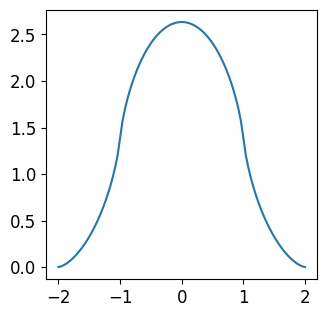

In [6]:
dd_norm = dd/(-a*pre_fac)
plt.plot(col_pts_aug[:, 0], dd_norm[:, 1])
# plt.show()
#plt.ylim([0, 3])

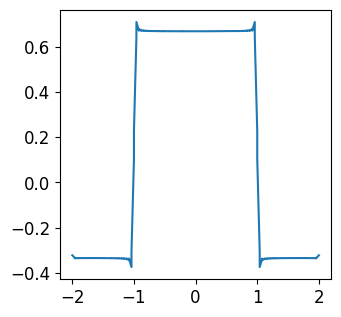

In [7]:
plt.plot(col_pts_aug[:, 0], t.reshape(-1, 2)[:, 1])
# plt.xlim([-1 - 10 * 2 * c / nelts, -1 + 10 * 2 * c / nelts])

#print("Calculated pressure between x = -", a , " and +", a , "is = ", t[101])
#print("Calculated pressure between |x| = ", a , " and ", c , " is = ", t[1])

 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.003e-06
Binary cluster tree depth = 1
Number of blocks = 4
Number of full blocks = 4
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 4 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.0181151
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
L2 Rel error 0.15206484448796292
 Now setting things for kernel ... 2DP1 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  0.00011028
Binary cluster tree depth = 5
Number of blocks = 250
Number of full blocks = 94
Number of low rank blocks = 156
Pattern Created 
 Loop on full blocks construction  
 N full blocks 94 
Loop on low rank blocks construction
N low rank blocks 156
dof_dimension: 2
Crea

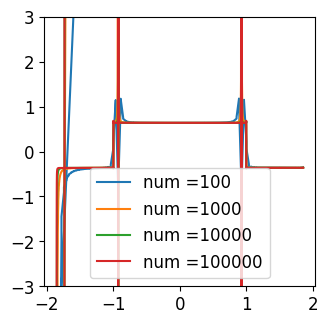

In [20]:
nelts_array = [10**i for i in range(2,6)]
rel_err_array = []

for nelts in nelts_array:
    # Mesh
    coor1D = np.linspace(-c, c, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # H-matrix parameters
    max_leaf_size = 100
    eta = 3.
    eps_aca = 1.e-4

    # Hmatrix
    kernel = "2DP1"
    elas_prop = np.array([E, nu])
    hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

    col_pts = np.zeros((conn.shape[0] * 2, conn.shape[1]))
    count = 0
    col_pts[count, :] = coor[0, :]
    count += 1
    for i in range(1, coor.shape[0] -  1):
        col_pts[count, :] = coor[i, :]
        count += 1
        col_pts[count, :] = coor[i, :]
        count += 1
    #col_pts[count, :] = coor[i+1, :]

    dd = np.zeros(col_pts.shape)

    pzl2 = np.sqrt(c**2 - a**2)
    x_pzl2 = col_pts[:, 0]*pzl2
    ctzl2 = np.sqrt(c**2 - col_pts[:, 0]**2)
    a_ctzl2 = a*ctzl2

    dd[:, 1] = pre_fac * (col_pts[:, 0]*np.log(abs((x_pzl2 + a_ctzl2)/(x_pzl2 - a_ctzl2))) - a*np.log(abs((pzl2 + ctzl2)/(pzl2 - ctzl2))))
    dd[:, 1][int(len(dd)/4)-1] = 0.6618431437
    dd[:, 1][int(len(dd)/4)] = 0.6618431437
    dd[:, 1][int(3*len(dd)/4)-1] = 0.6618431437
    dd[:, 1][int(3*len(dd)/4)] = 0.6618431437

    # calculate tractions
    t = hmat.matvec(dd.flatten())

    t_anal = np.zeros(col_pts.shape)
    t_anal[:, 1] = ct_pressure
    for i in range(len(t_anal)):
        if abs(col_pts[i][0])>=a:
            t_anal[i][1] = pz_pressure

    rel_err = np.linalg.norm(t - t_anal.flatten()) / t.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_err_array.append(rel_err)

    plt.plot(col_pts[:, 0], t.reshape(-1, 2)[:, 1], label = 'num =' + str(nelts))

    '''
    info
    dd_calc_norm = dd_calc/(a*pre_fac)
    plt.figure()
    #plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
    plt.plot(col_pts[:, 0], dd_calc_norm.reshape(-1, 2)[:, 1], ".")
    plt.plot(col_pts[:, 0], dd.reshape(-1, 2)[:, 1], ".")
    '''
plt.ylim([-3, 3])
plt.legend()

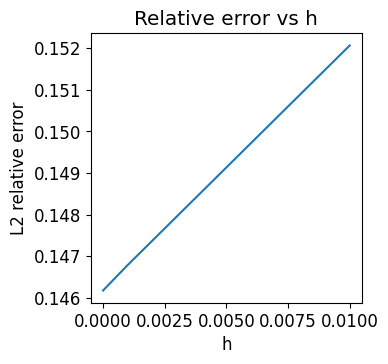

In [21]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

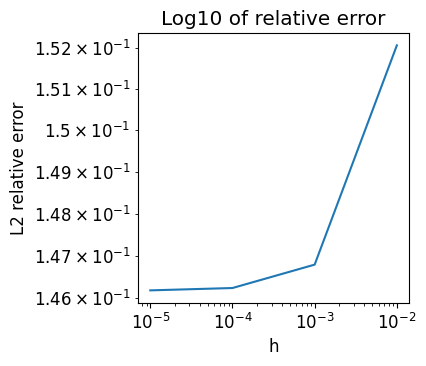

In [22]:
plt.figure()
plt.plot(h_array, rel_err_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [23]:
print(h_array)
print(rel_err_array)

log_h = np.log(np.asarray(h_array)[2:])
log_rel_array = np.log(np.asarray(rel_err_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

[0.01, 0.001, 0.0001, 1e-05]
[0.15206484448796292, 0.14678577175564364, 0.14623342562441582, 0.14617806207652195]
0.00016445375539285163
-1.9210364532935997


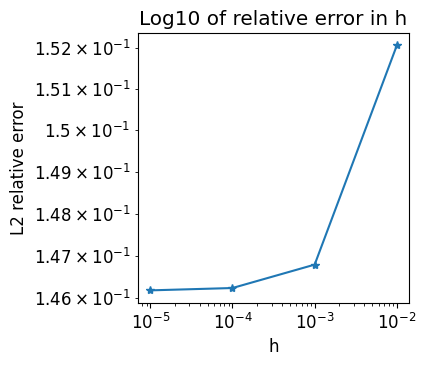

In [27]:
plt.figure()
plt.plot(h_array, rel_err_array, "*-")
#plt.plot(h_array, 0.5*np.array(h_array) ** (m) , "--")
plt.title("Log10 of relative error in h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log', base=10)
plt.xscale('log', base=10)
#saves fig - remember to remove
#plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
#plt.show()